In [23]:
from model import atp_graph, atp_pipeline
from data_wrangler import synthetic_data_gen, feature_extractor
import keras
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import tensorflow as tf
import IPython
import time
import os

In [24]:
t, Y = synthetic_data_gen.GP_functions_gen(samples=200)

In [25]:
def batcher(t, y, idx_list,batch_s = 32, window = 288,cut_sequence = True):
    '''
    cutting one long array to sequences of length 'window'.
    'batch_s' must be ≤ full array - window length
    '''
    
    
    if len(idx_list) < 1:
        print("warning- you didn't loop over the correct range")
        
    
    batch_s = min(batch_s, y.shape[0]-window)    
    idx = np.random.choice(len(idx_list), batch_s, replace = False)

    y = np.array([np.array(y)[idx_list[i]:idx_list[i]+window, :, :] for i in idx])
    t = np.array([np.array(t)[idx_list[i]:idx_list[i]+window, :, :] for i in idx])
    for i in sorted(idx, reverse=True): del idx_list[i]
    return t, y,idx_list

In [26]:
t.shape

(200, 100)

In [27]:
a,b,c = batcher(t[:, :, np.newaxis], Y, list(range(Y.shape[0])), window=1)

In [28]:
Y.shape

(200, 100, 1)

In [29]:
t[:, :, np.newaxis].shape

(200, 100, 1)

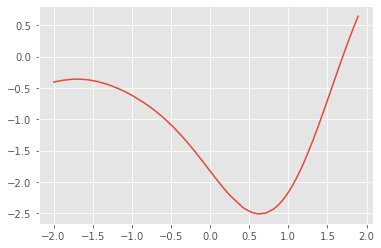

In [30]:
plt.plot(np.sort(t[0, :]), Y[0, np.argsort(t[0, :]), 0])
plt.show()

In [31]:
save_dir = "/Users/omernivron/Downloads/ATP_weights/RBF/"

#### Setup parameters

In [33]:
tf.random.set_seed(442)
opt = tf.keras.optimizers.Adam(3e-4)
run=2; heads=2
atp_model = atp_pipeline.atp_pipeline(num_heads=4, projection_shape_for_head=4, output_shape=64, rate=0.1, permutation_repeats=1,
                 bound_std=False, num_layers=3, enc_dim=32, xmin=0.1, xmax=2)

EPOCHS = 40; seq_l = Y.shape[1];
num_batches = 500
batch_s=20
mini = 50000
n_C_te =5

In [42]:
step = 1
tr_step = atp_graph.build_graph()

name_comp = 'run_' + str(run)
logdir = save_dir + '/logs/' + name_comp
folder = save_dir + '/ckpt/check_' + name_comp

if not os.path.exists(folder): os.mkdir(folder)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=atp_model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)

#### Training

In [43]:
Y.shape

(200, 100, 1)

In [44]:
t_tr.shape

(20, 100, 1)

In [45]:
if __name__ == '__main__':
    for epoch in range(EPOCHS):
        start = time.time()
        for batch_n in range(num_batches):

            n_C = 30
            n_T  = 70
            tr_ix = np.random.choice(np.arange(0, int(0.9 * Y.shape[0])), batch_s)
            y_tr = Y[tr_ix, :, :]
            t_tr = t[tr_ix, :, np.newaxis]

            μ, nll_pp, msex = tr_step(atp_model, opt, t_tr, y_tr, n_C, n_T, True )

            if ((batch_n % 100 == 0)):
                te_ix = np.random.choice(np.arange(int(0.9 * Y.shape[0]), Y.shape[0]), batch_s)
                y_te = Y[te_ix, :]
                t_te = t[te_ix, :]
                
                query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n = feature_extractor.make_features(t_te, y_te.squeeze(), n_C_te, batch_s=batch_s)
                μ_te, log_σ = atp_model(query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n)
                _,_,_, nll_pp_te, msex_te = losses.nll(y_te[:, n_C:n_C+n_T], μ_te, log_σ)

            if nll_pp_te < mini:
                mini = nll_pp_te
                IPython.display.clear_output(wait=True)
                print("epoch {} batch {} test lik pp: {}".format(epoch, batch_n, nll_pp)) 
                manager.save()
                step += 1
                ckpt.step.assign_add(1)
        print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

(20, None, 1)
(20, None, 1)
(20, 30, None, 1)
(20, 30, None, 1)


TypeError: in user code:

    File "/Users/omernivron/Documents/ATP/model/atp_graph.py", line 13, in train_step  *
        μ, log_σ = atp_model([x, y, n_C, n_T, training])
    File "/Users/omernivron/miniforge3/envs/tf_m1_n/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    TypeError: Exception encountered when calling layer "atp_pipeline_1" (type atp_pipeline).
    
    in user code:
    
        File "/Users/omernivron/Documents/ATP/model/atp_pipeline.py", line 63, in call  *
            y_diff, x_diff, d, x_n, y_n = self._DE([y, x, n_C, n_T, training])
        File "/Users/omernivron/miniforge3/envs/tf_m1_n/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        TypeError: Exception encountered when calling layer "de" (type DE).
        
        in user code:
        
            File "/Users/omernivron/Documents/ATP/data_wrangler/feature_extractor.py", line 80, in call  *
                y_diff,  x_diff,  d,  x_n,  y_n = self.derivative_function([y,  x,  n_C,  n_T])
            File "/Users/omernivron/Documents/ATP/data_wrangler/feature_extractor.py", line 166, in derivative_function  *
                ix = tf.argsort(tf.cast(tf.math.reduce_euclidean_norm((current_x - x_temp),
        
            TypeError: Input 'y' of 'AddV2' Op has type int32 that does not match type float32 of argument 'x'.
        
        
        Call arguments received:
          • inputs=['tf.Tensor(shape=(20, None, 1), dtype=float32)', 'tf.Tensor(shape=(20, None, 1), dtype=float32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=bool)']
    
    
    Call arguments received:
      • inputs=['tf.Tensor(shape=(20, 100, 1), dtype=float32)', 'tf.Tensor(shape=(20, 100, 1), dtype=float32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=int32)', 'tf.Tensor(shape=(), dtype=bool)']


### Inference

In [ ]:
t, y = batcher(client_300["t"][k:], client_300["300"][k:], batch_s=batch_s)
t, y, c, n = batch_sampler(t, y)

num_samples = 5
samples = []
for sample in range(num_samples):
    y_copy = np.copy(y[0, :])[np.newaxis, :]
    for i in range(int(c), int(c+n)):
        query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n = make_features(t[0, :][np.newaxis, :], y_copy, i, batch_s=1)
        crep = np.repeat(c, 1*(int(n)+int(c))).reshape(1, int(n)+int(c), 1)
        ŷ = atp((query_x, key_x, value_x, query_xy, key_xy, value_xy, mask, y_n[:, :, np.newaxis], crep), training=False)
        current_y = np.random.normal(ŷ[:, i, 0], np.exp(ŷ[:, i, 1]) + 0.001)
        y_copy[:, i] = current_y
    samples.append(y_copy)

In [ ]:
# plan: 
### hypo. : GP will do better on MHA-X alone as oppsed to MHA-XY alone 
